# 21.07 Challenge

Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

So here's what you should do. Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the [runtime](http://stackoverflow.com/questions/1557571/how-to-get-time-of-a-python-program-execution) of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

## Decision Trees and Random Forests with Kickstarter

### Description

This dataset consists of Kickstarter project information.  A project is a finite work with a clear goal that you’d like to bring to life. Think albums, books, or films.

### Variables

- id: Internal kickstarter ID
- name: Name of the project
- sub_category: More specific classification of the main category
- main_category: High level classification of the project
- currency: Currency used to support the project
- deadline: Project close date
- goal: Fundraising goal, denominated in USD
- launched: Project kickoff date
- pledged: Amount pledged by the Kickstarter community
- state: Current state of the project
- backers: Number of project backers
- country: Country pleged from 
- usd_pledged: Amount of money pledged in USD
- usd_pledged_real: No Description
- usd_goal_real: No description

Is it possible to guess the project's status based on the variables present in the data?

### Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn import ensemble
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# Decision Tree model 
import pydotplus
import graphviz
from sklearn import tree
from IPython.display import Image

### User Functions

In [2]:
# Plot a correlaiton matrix
def corr_plot(corr_mat,figsize):
    """
        Pass in a correlation matrix and figsize (as a tuple) and plot the corresponding heatmap.
    """
    plt.figure(figsize=figsize)

    sns.heatmap(corr_mat, square=True, annot=True, linewidth=0.5)
    plt.title(f"Correlation matrix of winsorized variables")

    # Fix display issues for this version of matplotlib
    b,t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b,t)
    # plt.yticks(rotation=360)

    plt.show();

### EDA

In [3]:
kickstarter_raw = pd.read_csv("ks-projects-201801.csv")

In [23]:
# Make a copy of the dataframe to work with
kickstarter = kickstarter_raw.copy()

# change the data type for "deadline" & "launched" to datetime
kickstarter["deadline"] = pd.to_datetime(kickstarter["deadline"])
kickstarter["launched"] = pd.to_datetime(kickstarter["launched"])

# Create a feature that shows the duration of the project
kickstarter["duration"] = kickstarter["deadline"] - kickstarter["launched"]
kickstarter["duration"] = kickstarter["duration"].dt.days.astype("int32")

# Create a feature that will mark successful camaigns == 1
kickstarter["successful"] = np.where(kickstarter["state"]=="successful",1,0)

In [24]:
# Take a look at unique values in the categorical columns
categorical_cols = kickstarter.select_dtypes(include="object")

cat_counts = list()

for i, col in enumerate(categorical_cols.columns):
    unique_count = kickstarter[col].nunique()

    cat_counts.append([col,unique_count])

cat_uniques = pd.DataFrame(cat_counts,columns=["cat_col", "unique_vals"])

cat_uniques

,cat_col,unique_vals
0,name,375764
1,category,159
2,main_category,15
3,currency,14
4,state,6
5,country,23


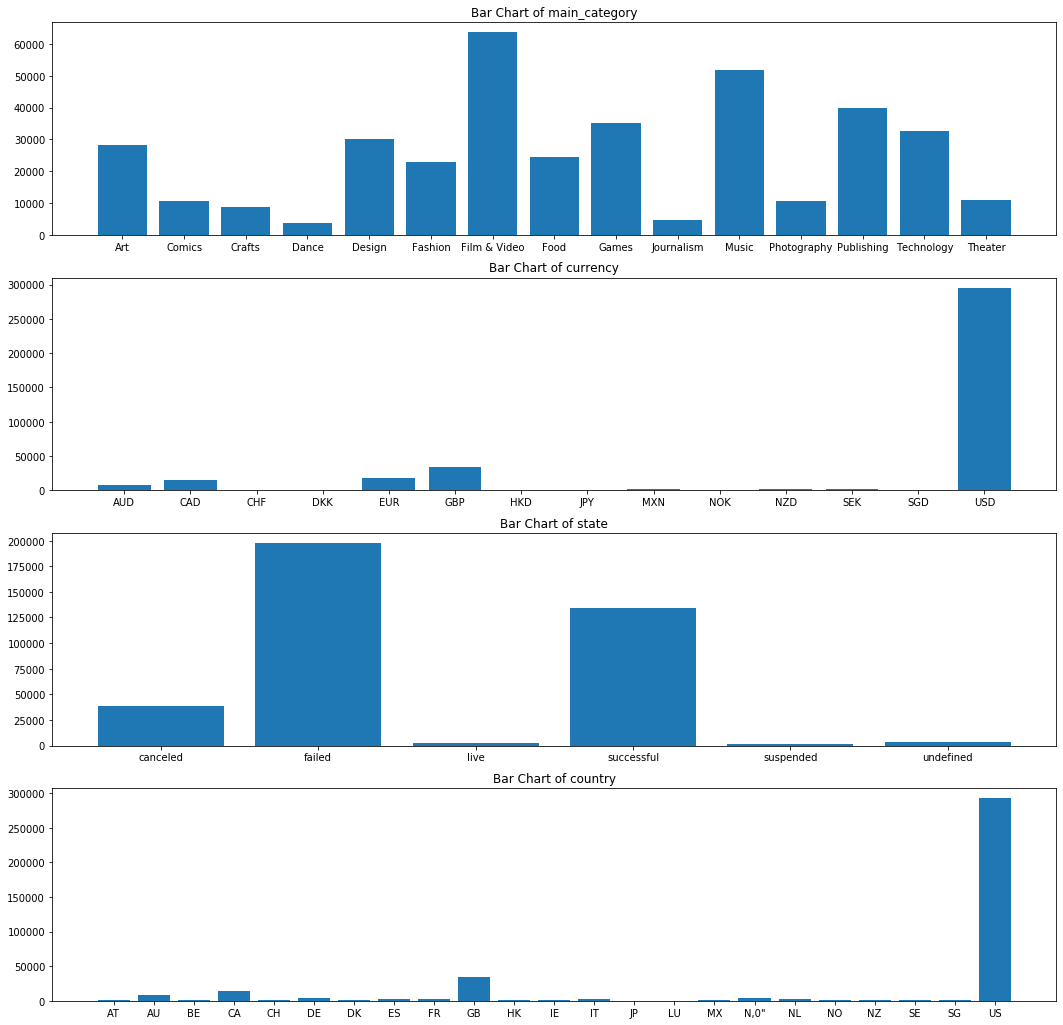

In [25]:
# Take a look as select categorical variables
plt.figure(figsize=(18,18))

for i, col in enumerate(kickstarter[["main_category","currency","state","country"]].columns, start=1):
    plt.subplot(4,1,i)
    plt.bar(
        kickstarter.groupby(f"{col}")[f"{col}"].count().index, 
        kickstarter.groupby(f"{col}")[f"{col}"].count()
    )

    plt.title(f"Bar Chart of {col}")

plt.show();

,goal,pledged,backers,usd_pledged,usd_pledged_real,usd_goal_real
goal,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd_pledged,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


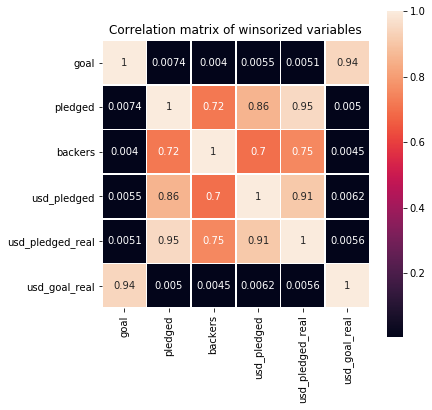

In [26]:
# Take a look at the correlations between continuous variables
continuous_cols = kickstarter.iloc[:,1:].select_dtypes(include=["int64","float64"]).copy()
continuous_corr = continuous_cols.corr()
display(continuous_corr)

# Get a column count to set the figure size 
col_count = len(continuous_cols.columns)

# Plot the correlation matrix
corr_plot(continuous_corr,(col_count,col_count))

In [27]:
continuous_vars = kickstarter[["goal","usd_pledged","usd_goal_real"]]

continuous_var_null_count = list()
for i, col in enumerate(continuous_vars.columns):
    null_count = kickstarter[col].isnull().count()
    continuous_var_null_count.append([col,null_count])

continuous_nulls = pd.DataFrame(continuous_var_null_count,columns=["continuous_col","count"])

continuous_nulls;

In [28]:
# Scale the continuous data using the preprocessing scaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(continuous_cols)

continuous_vars_scaled = pd.DataFrame(scaler.transform(continuous_cols), columns=continuous_cols.columns)

# Replace inf values with nans
continuous_vars_scaled = continuous_vars_scaled.replace([np.inf,-np.inf],np.nan)

# Now replace the nans with 0
continuous_vars_scaled = continuous_vars_scaled.fillna(0)

continuous_vars_scaled

,goal,pledged,backers,usd_pledged,usd_pledged_real,usd_goal_real
0,0.000010,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000009
1,0.000300,1.190325e-04,0.000068,4.916666e-06,1.190325e-04,0.000180
2,0.000450,1.081666e-05,0.000014,1.081666e-05,1.081666e-05,0.000270
3,0.000050,4.916666e-08,0.000005,4.916666e-08,4.916666e-08,0.000030
4,0.000195,6.308082e-05,0.000064,6.308082e-05,6.308082e-05,0.000117
...,...,...,...,...,...,...
378656,0.000500,1.229166e-06,0.000005,1.229166e-06,1.229166e-06,0.000301
378657,0.000015,7.620832e-06,0.000023,7.620832e-06,7.620832e-06,0.000009
378658,0.000150,9.833332e-07,0.000005,9.833332e-07,9.833332e-07,0.000090
378659,0.000150,9.833332e-06,0.000027,9.833332e-06,9.833332e-06,0.000090


In [29]:
# Run the PCA, setting the number of features
pca = PCA(n_components=3)

# Return an array of transformed values
pca.fit_transform(continuous_vars_scaled);

In [30]:
# Build a DataFrame of values from the PCA analysis
pca_df = pd.DataFrame(pca.components_,columns=continuous_vars_scaled.columns,index=range(3))

pca_df = np.abs(pca_df)

# Declare a set to store the continuous features
top_features = set()

for idx,row in pca_df.iterrows():
    # Return a series of correlations sorted from Top to Bottom
    top_row = row.sort_values(ascending=False)[:3]
    # Update the features set with the sorted values
    top_features.update(list(top_row.index))

In [31]:
# Loop over the categorical columns and create dummies
kickstarter_dummied = pd.get_dummies(kickstarter[["main_category","currency","state","country"]])

kickstarter_dummied

,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378657,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378658,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [32]:
# Bring the dataframes together for a new model
model = pd.concat([kickstarter_dummied,kickstarter["duration"],kickstarter[list(top_features)[:3]]],axis=1)
successful = kickstarter[["successful"]]

display(model.shape)
display(successful.shape)

(378661, 62)

(378661, 1)

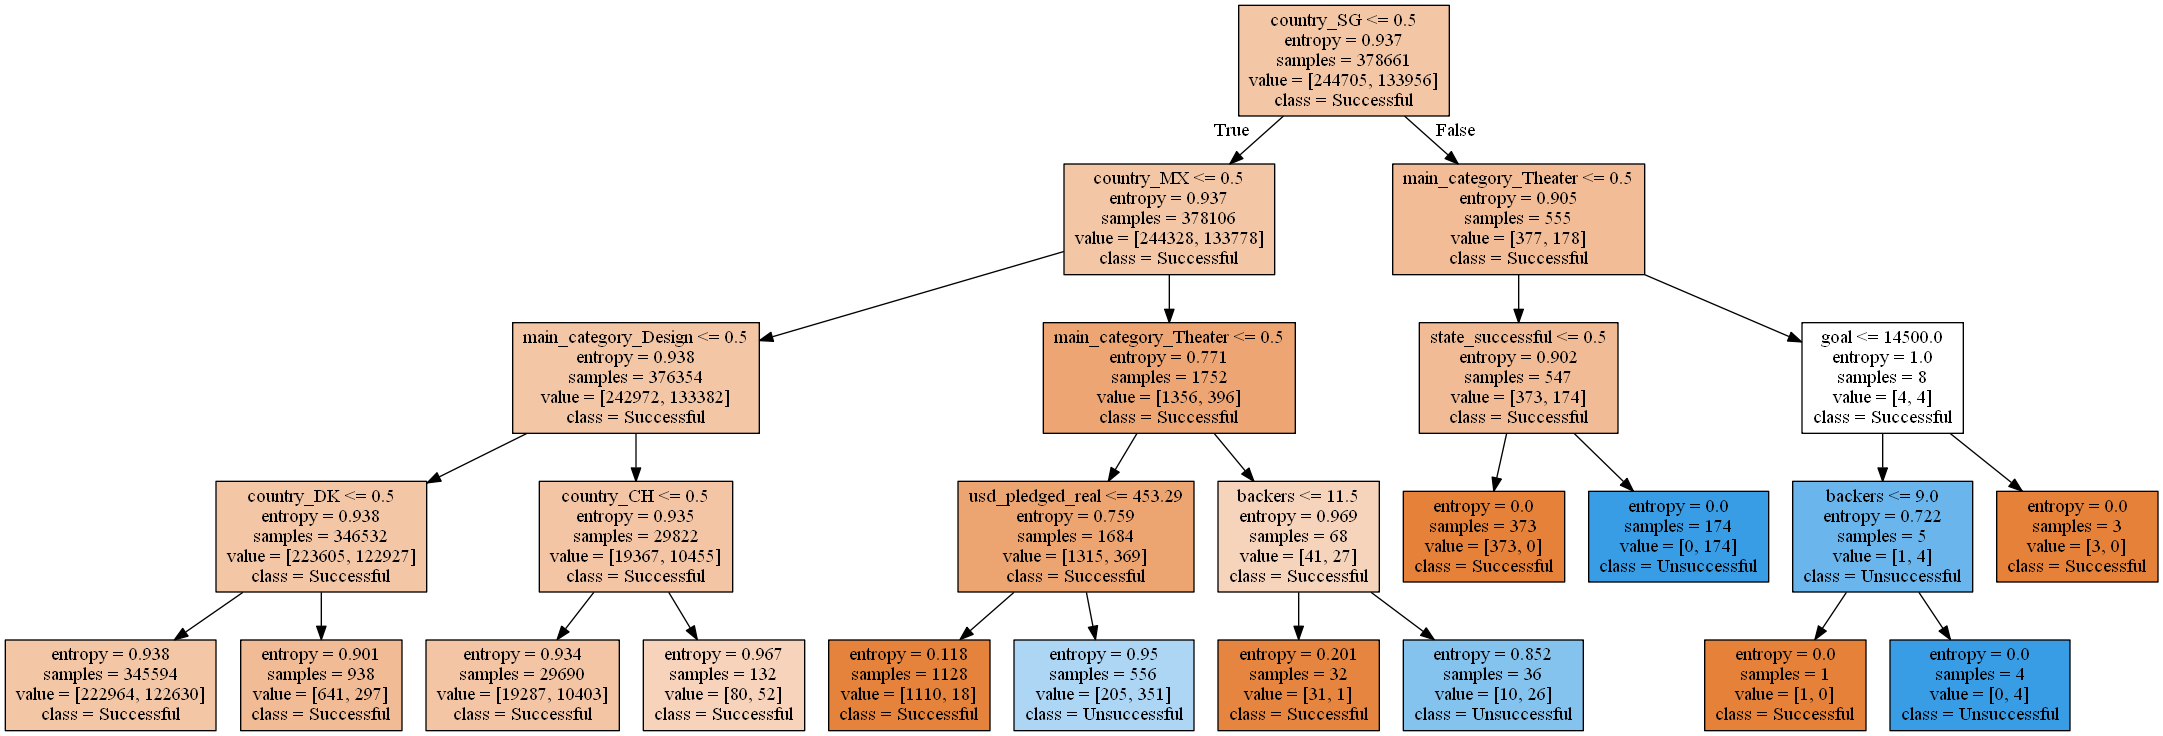

In [33]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion="entropy", 
    max_features=1,
    max_depth=4,
    random_state=1337
)

decision_tree.fit(model,successful)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, 
    out_file=None, 
    feature_names=model.columns, 
    class_names=["Successful", "Unsuccessful"], 
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [37]:
# Rerun the model and compare the results
rfc = ensemble.RandomForestClassifier()
# Model Features
X = model
# Target variable 
Y = kickstarter["successful"]

cross_val_score(rfc,X,Y,cv=10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])